<a href="https://colab.research.google.com/github/galvinograd/symple/blob/dataset_creation/sympy_generate_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Database

Each datapoint (row) should have the following obligatory entries (columns):

*   Simplifiable expression
*   ...

Auxiliary columns:
*   Simple form
*   Simplification difficulty (e.g. node count difference between complicated and simple forms)
*   Intermediate forms
*   ...


Store expressions as strings. Use str(expr) or sympy.srepr(expr) and sympy.parse_expr(expr_string).


# Generate database

Can be done in a few steps:

1.   Generate random (simple) expressions from list of atoms -- e.g. (x, y, z, randint(), ...). These should be about as complicated as a quadratic polynomial at most.
2.   Generate tuple (simple form, complicated form) from random input pair of simple expressions (could also use more than 2, or repeat one expression twice) (e.g. $e_1, e_2 \to (e_1 e_2, {\rm expand}(e_1 e_2)$)).
3. Further complicate given expression (e.g. $e \to e(1+e')-e e' $ for $e'$ a random subexpression of $e$, or a random expression). Store (simple form, complicated form).
4. Repeat 3 and store intermediate forms in tuple $(s, c(s), c(c(s)), \dots)$ for $s$ "simple" and $c$ "complicate".

Note: Perhaps step 2 is superfluous.


# Random expression generators

Perhaps use [this stackexchange post](https://stackoverflow.com/questions/71255333/how-to-generate-random-math-expression-trees-with-sympy) (but generalize to rational, etc.).


# Complicators

We need to implement a (small) palette of "complicators", as in the examples above. These can be radomly sampled during generation. They should give simplifiable expressions.

Polynomial complicators:

1. $e_1, e_2 \to (e_1 e_2, \,{\rm expand}(e_1 e_2))$
2. $e_1, e_2 \to (e_1, \, e_1 (1+e_2)-e_1 e_2)$
3. $e \to (e, \, e(1+e')-e e' )$ for $e'$ a random subexpression of $e$, or a random expression.
4. ...

Rational complicators:

0. $e \to \left( \frac{1}{e},\, \frac{e'}{ {\rm expand}(e e')}    \right)   $ for $e'$ a random subexpression of $e$, or a random expression.
1. $e \to \left(\frac{1}{e}, \, \frac{e+e'}{e e'} - \frac{1}{e'} \right) $ for $e'$ a random subexpression of $e$, or a random expression.
2. $e_1, e_2 \to \left(\frac{1}{e_1}+\frac{1}{e_2}, \, \frac{e_1+e_2}{{\rm expand}(e_1 e_2)}   \right)  $
3. ...







In [1]:
import numpy as np
from sympy import *

x, y, z = symbols("x y z")

In [2]:
# from sympy import init_printing
init_printing()
from IPython.display import display

In [3]:
def leaf_count(expr):
    args = expr.args
    if args:
        return sum(leaf_count(a) for a in args)
    else:
        return 1

In [4]:
def node_count(expr):
    # args = expr.args
    if not expr.is_Atom:
        return 1 + sum(leaf_count(a) for a in expr.args)
    else:
        return 1

In [5]:
def get_coords(expr, depth=np.inf, height=0, exclude=[]):
    if height <= 0 and not expr.func in exclude:
        coords = [[]]
    else:
        coords = []
    if expr.is_Atom or depth == 0:
        return coords

    args = list(enumerate(expr.args))
    if "exponents" in exclude and expr.func == Pow:
        args = args[:-1]
    for i, a in args:
        coords += [
            [
                i,
            ]
            + c
            for c in get_coords(a, depth=depth - 1, height=height - 1)
        ]
    return coords

In [8]:
def get_subexpression(expr, coord):
    if coord:
        return get_subexpression(expr.args[coord[0]], coord[1:])
    return expr

In [9]:
def get_nodes(expr):
    def _get_nodes(e, p):
        if not e.is_Atom:
            return [tree_node(e, p)] + sum([_get_nodes(a, e) for a in e.args], [])
        else:
            return [tree_node(e, p)]

    return _get_nodes(expr, None)

In [10]:
def map_on_subexpression(function, expr, coord, *funcargs, **funckwargs):
    """
    coord: a list representing directions to traverse the tree from the trunk to some particular subexpression.

    Might be inefficient implementation... This is because sympy expressions seemingly cannot be changed in-place.
    """
    if coord:
        i = coord.pop(0)
        return expr.func(
            *(
                expr.args[:i]
                + (
                    map_on_subexpression(
                        function, expr.args[i], coord, *funcargs, **funckwargs
                    ),
                )
                + expr.args[i + 1 :]
            )
        )
    return function(expr, *funcargs, **funckwargs)

In [11]:
expr = (x**2 - x + 1) ** 4
print("The leaf count before expanding:", leaf_count(expr), node_count(expr))
expr = expand(expr)
print("The leaf count after expanding:", leaf_count(expr), node_count(expr))
expr = simplify(expr)
print("The leaf count after simplifying:", leaf_count(expr), node_count(expr))
expr

The leaf count before expanding: 6 7
The leaf count after expanding: 23 24
The leaf count after simplifying: 23 24


 8      7       6       5       4       3       2          
x  - 4⋅x  + 10⋅x  - 16⋅x  + 19⋅x  - 16⋅x  + 10⋅x  - 4⋅x + 1

# Random generator

In [12]:
from random import choice, randint
from sympy import FunctionClass, Add, Mul, cos, sin, binomial, arity, S

In [13]:
def random_args(n, atoms, funcs, evaluate=True):
    a = funcs + atoms
    g = []
    for _ in range(n):
        ai = choice(a)
        if isinstance(ai, FunctionClass):
            g.append(ai(*random_args(arity(ai), atoms, funcs), evaluate=evaluate))
        else:
            g.append(ai)
    return g


def random_expr(ops, atoms, funcs=(), evaluate=True, inversion_prob=0.1):
    types = [Add, Mul]
    atoms = tuple(atoms)
    while 1:
        e = S.Zero
        while e.count_ops() < ops:
            _ = choice(types)(
                *random_args(randint(1, 3), atoms, funcs, evaluate=evaluate),
                evaluate=evaluate,
            )
            e = choice(types)(
                e,
                _ ** np.random.choice((1, -1), p=(1 - inversion_prob, inversion_prob)),
                evaluate=evaluate,
            )
            if e is S.NaN:
                break
        else:
            return e


def random_expr_if_none(expr, *args, **kwargs):
    return expr if expr is not None else random_expr(*args, **kwargs)


def expr_grabber(l, *args, **kwargs):
    """
    l should have the form [None, (actual expressions)]
    """
    prob = 0.1

    def random_from_list():
        p = np.ones(len(l)) * (1 - prob) / len(l)
        p[0] += prob
        expr = np.random.choice(l, p=p)
        return expr if expr is not None else random_expr(*args, **kwargs)

    return random_from_list


def random_coord(expr, **kwargs):
    return choice(get_coords(expr, **kwargs))


def random_subexpression(expr, **kwargs):
    coord = random_coord(expr, **kwargs)
    return (coord, get_subexpression(expr, coord))

# Complicator

In [14]:
import inspect


def gen_trick_1(e1, e2):
    return (e1 * e2, expand(e1 * e2))


def gen_trick_2(e1, e2):
    return (1 / e1 + 1 / e2, (e1 + e2) / (expand(e1 * e2)))


gen_tricks = [gen_trick_1, gen_trick_2]


def generate_simplifiable(eg):
    trick = np.random.choice(gen_tricks)
    return trick(*(eg() for _ in inspect.signature(trick).parameters))

In [15]:
def comp_trick_1(e, eg):
    ep = eg()
    return expand(e * ep) / ep


def comp_trick_2(e, eg):
    ep = eg()
    return e * (1 + ep) - expand(e * ep)


def comp_trick_3(e, eg):
    ep = eg()
    return expand(e * ep) / ep


comp_tricks = [comp_trick_1, comp_trick_2, comp_trick_3]

In [16]:
# First approach - uses "comp tricks" to obtain equivalent expression. Currently seems to be to easy for "simplify"
def complicate(n=3):
    l = [None]
    eg = expr_grabber(l, 3, (randint(1, 5), x, y))
    esimp, ecomp = generate_simplifiable(eg)
    print(f"The node count of the simple expression is: {node_count(esimp)}")
    print(f"The node count of the complicated expression is: {node_count(ecomp)}")
    l += list(esimp.args)
    for _ in range(n):
        trick = np.random.choice(comp_tricks)
        coord, subexp = random_subexpression(
            ecomp, depth=3, height=1, exclude=["exponents"]
        )
        ecomp, l = (
            map_on_subexpression(
                lambda x: trick(x, eg),
                ecomp,
                # random_node(ecomp,depth=3, height =1),
                coord,
            ),
            # trick(ecomp, eg),
            l + [subexp],
        )
        # l = [None]+l[-6:]
        print(f"The node count of the complicated expression is: {node_count(ecomp)}")
    return esimp, ecomp

In [17]:
# Second approach - only generates new, inequivalent expressions. Seems to be harder to crack


def complicate(n=7, rand_gen_args=(3, (randint(1, 5), x, y)), **kwargs):
    list_of_expressions = [None]
    eg = expr_grabber(list_of_expressions, *rand_gen_args, **kwargs)
    for _ in range(n):
        esimp, ecomp = generate_simplifiable(eg)
        # print(f"The node count of the simple expression is: {node_count(esimp)}")
        # print(f"The node count of the complicated expression is: {node_count(ecomp)}")
        list_of_expressions += list(esimp.args) + [esimp]
        # make sure not to use too simple subexpressions:
        list_of_expressions = [None] + list_of_expressions[-6:]
    return esimp, ecomp

# Generate and save dataset

In [18]:
from itertools import product

configs = [
    {
        "rand gen args": (3, vars),
        "number of complications": n,
        "number of datapoints": 100,
    }
    for vars, n in product([(x,), (x, y), (x, y, z)], [5, 7])
]

In [30]:
datapoints = []
for config in configs:
    for _ in range(config["number of datapoints"]):
        esimp, ecomp = complicate(
            n=config["number of complications"],
            rand_gen_args=(lambda rga: (rga[0], (randint(1, 5),) + rga[1]))(
                config["rand gen args"]
            ),
        )
        secomp = simplify(ecomp)
        datapoints.append(
            {
                "expr": ecomp,
                "simp": esimp,
                "simplified": secomp,
                "node count expr": node_count(ecomp),
                "node count simp": node_count(esimp),
                "node count simplified": node_count(secomp),
            }
        )

In [29]:
import json
import pandas as pd

In [90]:
df = pd.DataFrame.from_dict(datapoints)
df[df.columns[:3]] = df[df.columns[:3]].map(str)
df["difficulty"] = df["node count expr"] - df["node count simp"]
with open("data/data.json", "w") as f:
    df.to_json(f)

# Analyze dataset

In [91]:
with open("data/data.json", "r") as f:
    df = pd.read_json(f)
df[df.columns[:3]] = df[df.columns[:3]].map(sympify)

In [92]:
df.head()

,expr,simp,simplified,node count expr,node count simp,node count simplified,difficulty
0,(5*x**2/(5*x + 25) + 1/(x*(x + 10) + x))*(5*x*...,x*(x + 10) + x + (5*x + 25)/(5*x**2),(x**4 + 11*x**3 + x + 5)/x**2,24,11,10,13
1,x**4,x**4,x**4,3,3,3,0
2,1/(100*x**3 + 25002*x**2/25 + 12504*x/5 + 2),1/((x + 5)*(2*x + 10)*(50*x + 1/25)),25/(2500*x**3 + 25002*x**2 + 62520*x + 50),11,12,12,-1
3,(x*(x + 6) + 2*x + 1/(9*x*(x + 6)))/(x**2/(9*x...,9*x*(x + 6) + 1/(x*(x + 6) + 2*x),(9*x**2*(x + 6)*(x + 8) + 1)/(x*(x + 8)),29,11,14,18
4,(x + 4)*(1024*x**2/(x + 4) + 2)/(2048*x**2),1/2 + (x + 4)/(1024*x**2),(512*x**2 + x + 4)/(1024*x**2),13,7,9,6


In [89]:
[display(*d) for d in df[["expr", "simp"]].head().values]
pass

⎛     2                   ⎞                       
⎜  5⋅x            1       ⎟ ⎛   3       2        ⎞
⎜──────── + ──────────────⎟⋅⎝5⋅x  + 80⋅x  + 275⋅x⎠
⎝5⋅x + 25   x⋅(x + 10) + x⎠                       
──────────────────────────────────────────────────
                          2                       
                       5⋅x                        

                 5⋅x + 25
x⋅(x + 10) + x + ────────
                      2  
                   5⋅x   

 4
x 

 4
x 

               1               
───────────────────────────────
                2              
     3   25002⋅x    12504⋅x    
100⋅x  + ──────── + ─────── + 2
            25         5       

               1                
────────────────────────────────
(x + 5)⋅(2⋅x + 10)⋅(50⋅x + 1/25)

                       1     
x⋅(x + 6) + 2⋅x + ───────────
                  9⋅x⋅(x + 6)
─────────────────────────────
       2                     
      x             8⋅x      
  ─────────── + ───────────  
     2             2         
  9⋅x  + 54⋅x   9⋅x  + 54⋅x  

                     1       
9⋅x⋅(x + 6) + ───────────────
              x⋅(x + 6) + 2⋅x

        ⎛      2    ⎞
        ⎜1024⋅x     ⎟
(x + 4)⋅⎜─────── + 2⎟
        ⎝ x + 4     ⎠
─────────────────────
             2       
       2048⋅x        

1    x + 4 
─ + ───────
2         2
    1024⋅x 

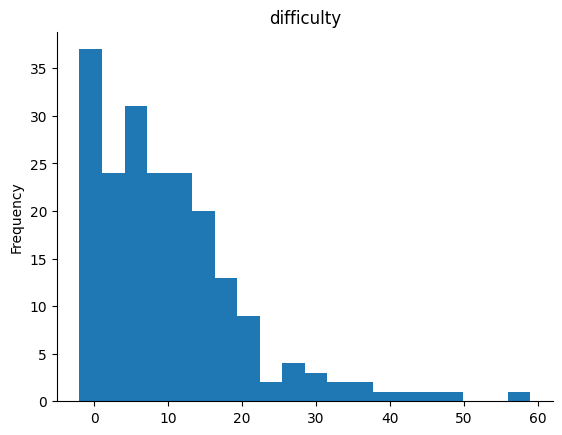

In [93]:
# @title difficulty

from matplotlib import pyplot as plt

df["difficulty"].plot(kind="hist", bins=20, title="difficulty")
plt.gca().spines[
    [
        "top",
        "right",
    ]
].set_visible(False)

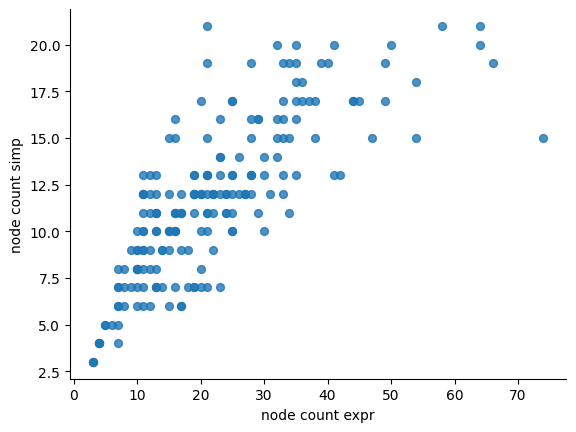

In [71]:
# @title node count expr vs node count simp

from matplotlib import pyplot as plt

df.plot(kind="scatter", x="node count expr", y="node count simp", s=32, alpha=0.8)
plt.gca().spines[
    [
        "top",
        "right",
    ]
].set_visible(False)

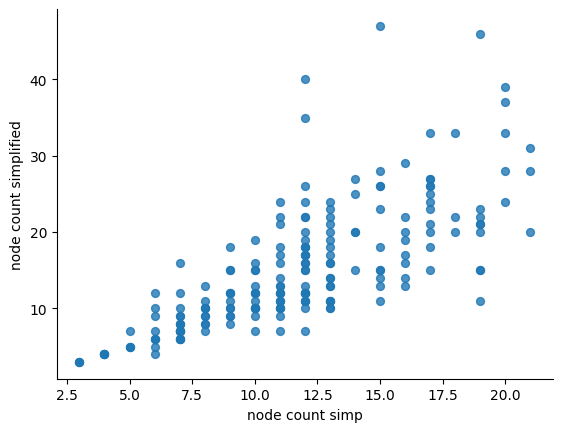

In [73]:
# @title node count simp vs node count simplified

from matplotlib import pyplot as plt

df.plot(kind="scatter", x="node count simp", y="node count simplified", s=32, alpha=0.8)
plt.gca().spines[
    [
        "top",
        "right",
    ]
].set_visible(False)

# Miscellaneous

In [ ]:
collect(expr, x**2 - x + 1)

 8      7       6       5       4       3       2          
x  - 4⋅x  + 10⋅x  - 16⋅x  + 19⋅x  - 16⋅x  + 10⋅x  - 4⋅x + 1

In [ ]:
display(expr)
map_on_subexpression(lambda a: a.subs(x, y), expr, [3])

 8      7       6       5       4       3       2          
x  - 4⋅x  + 10⋅x  - 16⋅x  + 19⋅x  - 16⋅x  + 10⋅x  - 4⋅x + 1

 8      7       6       4       3       2             5    
x  - 4⋅x  + 10⋅x  + 19⋅x  - 16⋅x  + 10⋅x  - 4⋅x - 16⋅y  + 1